In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import math
import torch

from wave_propagation.wavelet import generate_ricker_wavelet

# Wavelet check

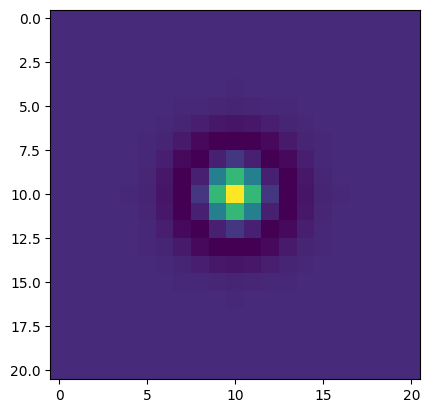

In [3]:
wavelet = generate_ricker_wavelet(npoints=10, sigma=1.5)
plt.imshow(wavelet, interpolation="nearest", cmap=cm.viridis)
plt.show()

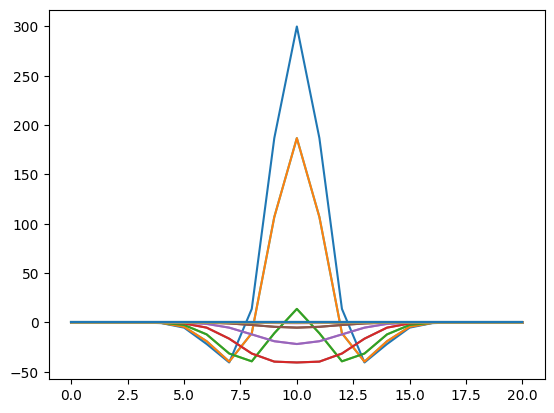

In [4]:
plt.plot(wavelet)

# Computational area

In [9]:
def init_2d_media(nx: int, ny: int, time_step: int = 1, x_step: int = 1, device="cpu") -> torch.Tensor:
    velocity = np.zeros((nx, ny))  # Velocity model in m/s. In case of acoustic pressure waves would be P velocities.

    # Fill velocity model
    velocity[0:nx, 0:ny] = 1500
    velocity[0:nx, ny // 4 :] = 2000
    velocity[0:nx, ny // 2 :] = 3000
    velocity[0:nx, int(ny // 1.5) :] = 4000
    # velocity[650:950, 220:] = 0.5

    assert time_step <= x_step / (np.sqrt(2) * np.max(velocity)), "Time step is too large for the given velocity and grid step"
    # Compute tau and kappa from the velocity field and spatial steps
    tau = velocity**2 * time_step**2 / x_step**2  # Combination of Velocity and Spatial Steps for Wave Equation
    kappa = (
        time_step * velocity / x_step
    )  # Combination of Velocity and Spatial Steps for Absorbing Boundary Condition (MUR)
    return torch.from_numpy(velocity).to(device), torch.from_numpy(tau).to(device), torch.from_numpy(kappa).to(device)

In [10]:
velocity, tau, kappa = init_2d_media(300, 200, 0.001, 25)

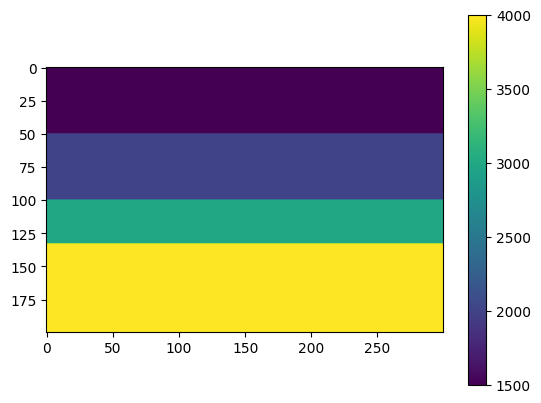

In [11]:
ims = plt.imshow(velocity.T, interpolation="bilinear", cmap=cm.viridis)
plt.colorbar(ims)

In [12]:
from wave_propagation.engine.propagation_2d import build_laplacian_kernel

kernel = build_laplacian_kernel(kernel_size=5)
print(kernel.shape)
print(kernel)

torch.Size([5, 5])
tensor([[ 0.0000,  0.0000, -0.0833,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.3333,  0.0000,  0.0000],
        [-0.0833,  1.3333, -5.0000,  1.3333, -0.0833],
        [ 0.0000,  0.0000,  1.3333,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0833,  0.0000,  0.0000]], dtype=torch.float64)


# Main simulation

In [13]:
import pygame
import time

from wave_propagation.engine.propagation_2d import build_laplacian_kernel, solve_one_step
from wave_propagation.wavelet import inject_wavelet

def draw_snapshot(display, array, offset, cellsize):
    dimx, dimy = array.shape
    colored_array = apply_palette(array)
    norm_vel = normalize_array(velocity)
    colored_vel = apply_palette(norm_vel, cmap_name="viridis")
    surf = pygame.surfarray.make_surface(colored_array)
    surf.set_alpha(100)
    background = pygame.surfarray.make_surface(colored_vel)
    display.blit(pygame.transform.scale(background, (dimx * cellsize, dimy * cellsize)), offset)
    display.blit(pygame.transform.scale(surf, (dimx * cellsize, dimy * cellsize)), offset)

def normalize_array(arr):
    arr_min, arr_max = arr.min(), arr.max()
    normalized = mcolors.Normalize(vmin=arr_min, vmax=arr_max)
    return normalized(arr)


def apply_palette(arr, cmap_name='gray'):
    cmap = plt.get_cmap(cmap_name)
    rgba_img = cmap(arr)
    rgb_img = np.delete(rgba_img, 3, 2)  # Remove alpha channel
    return (rgb_img * 255).astype(np.uint8)

def run_simulation(nx: int = 300, ny: int = 200, time_step: int = 0.001, x_step: int = 25, laplacian_kernel_size: int = 9, cellsize: int = 1):
    global font
    pygame.init()
    pygame.font.init()
                   
    font = pygame.font.SysFont('Consolas', 15)    
    display = pygame.display.set_mode((nx * cellsize, ny * cellsize))
    pygame.display.set_caption("Solving the 2d Wave Equation")

    velocity, tau, kappa = init_2d_media(nx, ny, time_step, x_step)
    wavelet = generate_ricker_wavelet(npoints=10, sigma=1.5)
    wavefield = torch.from_numpy(np.zeros((3, nx, ny)))
    wavefield = inject_wavelet(wavefield, wavelet, nx//2, 30, 1)
    laplacian_kernel = build_laplacian_kernel(kernel_size=laplacian_kernel_size)

    wavefield = wavefield.to(device="cuda")
    wavelet = wavelet.to(device="cuda")
    tau = tau.to(device="cuda")
    kappa = kappa.to(device="cuda")
    laplacian_kernel = laplacian_kernel.to(device="cuda")

    tick = 0
    last_tick = 0
    fps = 0
    start_time = time.time()
    first_frame = True
    
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return

        tick = tick + 1

        current_time = time.time() 
        if current_time - start_time > 0.5:
            fps = (tick-last_tick) / (current_time - start_time) 
            start_time = time.time()
            last_tick = tick


        wavefield = solve_one_step(wavefield, tau, kappa, laplacian_kernel)
        wavefield_cpu = wavefield.to("cpu")
        draw_snapshot(display, wavefield_cpu[0], (0,0), cellsize)
        pygame.display.update()

        # if first_frame:
        #     first_frame = False
        #     time.sleep(10) # For recording
        # else:
        #     pass

pygame 2.6.1 (SDL 2.28.4, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [14]:
run_simulation(nx=1200, ny=800)

# Benchmarks

In [15]:
from wave_propagation.engine.propagation_2d import build_laplacian_kernel, solve_one_step
from wave_propagation.wavelet import inject_wavelet

nx, ny = 1200, 800
time_step, x_step = 0.001, 25
velocity, tau, kappa = init_2d_media(nx, ny, time_step, x_step, device="cuda")
wavelet = generate_ricker_wavelet(npoints=10, sigma=1.5, device="cuda")
wavefield = torch.from_numpy(np.zeros((3, nx, ny))).to("cuda")
wavefield = inject_wavelet(wavefield, wavelet, nx//2, 10, 1)
laplacian_kernel = build_laplacian_kernel(kernel_size=5, device="cuda")

In [16]:
%%timeit
solve_one_step(wavefield, tau, kappa, laplacian_kernel)

1.55 ms ± 61.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
from wave_propagation.engine.propagation_2d import build_laplacian_kernel, solve_one_step
from wave_propagation.wavelet import inject_wavelet

nx, ny = 1200, 800
time_step, x_step = 0.001, 25
velocity, tau, kappa = init_2d_media(nx, ny, time_step, x_step)
wavelet = generate_ricker_wavelet(npoints=10, sigma=1.5)
wavefield = torch.from_numpy(np.zeros((3, nx, ny)))
wavefield = inject_wavelet(wavefield, wavelet, nx//2, 10, 1)
laplacian_kernel = build_laplacian_kernel(kernel_size=5)

In [18]:
%%timeit
solve_one_step(wavefield, tau, kappa, laplacian_kernel)

33.5 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
